<a href="https://colab.research.google.com/github/beekal/MachieneLearningProjects/blob/master/0%20Basics%20-%20TF/TF_2_0_Basics%20Revision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TF 2.0 Topics Covered
1. TF.Data : A single point of entry to handle any/ varied data type ranging from pandas, csv, image, text, TfRecordByte e.t.c
2. TFX: Tensorflow extended,  which aims to  provided end to end TF ecosystem from its  research/ prototype to  the server deployment. It includes the following  all of  which we will cover in this notebook
  -  TF validation : Used to validate the data
  -  TF Transform : Used to transform the data to its modeling state
  -  TF Modeling / Analysis : Used to create the model and evaluate its performance. Reiterate until satisfactory Metric reached.
  - TF Serving: Used to serve the model to production with versioning/ Rollback capabilities.

REF: https://www.tensorflow.org/tfx 

In [1]:
import tensorflow as tf
import numpy

print(f'TF version : ', tf.__version__)

TF version :  2.2.0-rc3


## TF.Data
Depending on the data source you wil have to use different TF data load calls
  - Data in memory :
      - tf.data.Dataset.from_tensors() or
      - tf.data.Dataset.from_tensor_slices() : For data in memory
      - tf.data.TFRecordDataset(): For Large Files
      - tf.data.TextLineDataset() : For text File
      - From CSV : Supports lazy incremental data load
      - From DataFrame : Loads all data in mem

1. **TFRecordDataset** : If we want to read the data efficiently or are dealing with the large files, it is best to use the TFRecordDataSet. It stores the data in the binary format of smaller size(100-200 MB chunk) and hence is faster / easier to read. To know more on [How to create a TFRecordDataset click here](www.tensorflow.org/tutorials/load_data/tfrecord).

In [44]:
def hprint(text):
  print("\n"+"="*80+"\n\t\t"+text+"\n"+"="*80)

hprint('READING FROM MEMORY')
d_mem = tf.data.Dataset.from_tensor_slices([1,2,3])
print(f' Tf.Data from memory : ' ,[e.numpy() for e in d_mem])
it = iter(d_mem)
print(f' Tf.Data from memory using iterator : ' ,next(it).numpy())

# French street name sign FRecordDataset
hprint('READING FROM TF RECORD DATASET')
fsns_file = tf.keras.utils.get_file("fsns.tfrec", "https://storage.googleapis.com/download.tensorflow.org/data/fsns-20160927/testdata/fsns-00000-of-00001")
fsns_tfrecord = tf.data.TFRecordDataset(filenames= [fsns_file])
print(fsns_tfrecord)
byte_example = next(iter(fsns_tfrecord))
# Displays all the example data
# print(tf.train.Example.FromString(byte_example.numpy()) )
print(tf.train.Example.FromString(byte_example.numpy()).features.feature['image/text'] ) 

hprint('READING TEXT FILE')
dir = 'https://storage.googleapis.com/download.tensorflow.org/data/illiad/'
file_names = ['cowper.txt', 'derby.txt', 'butler.txt']
file_paths = [tf.keras.utils.get_file(f, dir+f) for f in file_names ]
f_dataset =   tf.data.TextLineDataset(file_paths)
for line in f_dataset.take(3):
  print('First line of each file  :', line.numpy() )
# To learn how to Shuffle Text lines between files, see https://www.tensorflow.org/guide/data#consuming_text_data

hprint('READING FROM DATAFRAME')
import pandas as pd
titanic_csv = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
df =  pd.read_csv(titanic_csv, index_col=None)
t_dataset = tf.data.Dataset.from_tensor_slices(dict(df))
for feat in t_dataset.take(1):
  for col_name, val in feat.items():
    print("{:20s}: {}".format(col_name, val))


hprint('READING FROM CSV')
t_batch = tf.data.experimental.make_csv_dataset(\
                titanic_csv, batch_size=2, label_name="survived", \
                select_columns=['sex','age', 'class', 'fare', 'survived']                
                )
for feat, label in t_batch.take(1):
  print(f'Label (Survived) :', label)
  for col_name, val in feat.items():
    print("{:20s} : {}".format(col_name, val))

hprint('READING FROM CSV:  Lower level with finer grain control')
t_type = [tf.int32, tf.string, tf.float32, tf.int32, tf.int32, tf.float32, tf.string, tf.string, tf.string, tf.string]
t1_dataset = tf.data.experimental.CsvDataset(titanic_csv, t_type, header=True )
for line in t1_dataset.take(2):
  print([x.numpy() for x in line])

hprint('READING FROM a zip file')
credit_card_file = tf.keras.utils.get_file(fname='creditcard.zip', extract=True, origin='https://storage.googleapis.com/download.tensorflow.org/data/creditcard.zip' )
credit_card_path= credit_card_file.replace('.zip','.csv')
credit_card_ds = tf.data.experimental.make_csv_dataset(credit_card_path, batch_size=2048,\
                        label_name='Class', column_defaults=[float()]*30 + [int()])



		READING FROM MEMORY
 Tf.Data from memory :  [1, 2, 3]
 Tf.Data from memory using iterator :  1

		READING FROM TF RECORD DATASET
<TFRecordDatasetV2 shapes: (), types: tf.string>
bytes_list {
  value: "Rue Perreyon"
}


		READING TEXT FILE
First line of each file  : b"\xef\xbb\xbfAchilles sing, O Goddess! Peleus' son;"
First line of each file  : b'His wrath pernicious, who ten thousand woes'
First line of each file  : b"Caused to Achaia's host, sent many a soul"

		READING FROM DATAFRAME
survived            : 0
sex                 : b'male'
age                 : 22.0
n_siblings_spouses  : 1
parch               : 0
fare                : 7.25
class               : b'Third'
deck                : b'unknown'
embark_town         : b'Southampton'
alone               : b'n'

		READING FROM CSV
Label (Survived) : tf.Tensor([0 0], shape=(2,), dtype=int32)
sex                  : [b'male' b'male']
age                  : [28.  9.]
fare                 : [56.4958 31.3875]
class                : [b

### TF.Data: Generator
  - **Read From Mixed datatype + Lazy Data Loading**

  - Use generator to convert each elements into a tf.Data Dataset 
  - Example : Load image data with generator. i.e We do not need to read 5+ GB of data and fill it up in  memory / waste memory.

In [36]:
person_data=  ([{ 'age':18,'name':'Hary' },
              { 'age':30,'name':'Sam' }
              ])
person_data
person =  tf.data.Dataset.from_generator( lambda: person_data, {"age": tf.int32, "name":tf.string}  )
print(person)
print(list(person.as_numpy_iterator()))


<FlatMapDataset shapes: {age: <unknown>, name: <unknown>}, types: {age: tf.int32, name: tf.string}>
[{'age': 18, 'name': b'Hary'}, {'age': 30, 'name': b'Sam'}]


## TF Transform :
We can apply different type of transformations as per our need
  - Dataset.map() : Per-Element operations
  - Dataset.filter(): Per-element Filter Operation
  - Dataset.reduce(): Reduce transfomations to single scalar value
  - Dataset.batch(): Per-batch operations
  - Dataset.shuffle(): Shuffle data
  - tf.py_function(): When tensorflow op is insufficient/  to call external python library e.g rotate image
  - Dataset Sampling :  Resample imbalanced data.

### Dataset.map: Parallelisation/ SpeedUp
If we want to speed up the dataset.map then we must specify the num_parallel_calls. 
  - Not defined : Process sequentially
  - tf.data.experimental.AUTOTUNE : parallel calls set based on available CPU 



		Dataset.map():
All elements Increment by 1
[2, 3, 4]
Using function  [3, 4, 5]

		Dataset.map(): Read Data from TFRecordDataSet using MAP()
tf.Tensor(b'Rue Perreyon', shape=(), dtype=string)


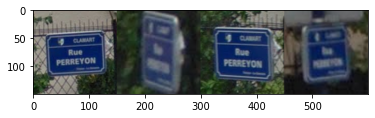


		Dataset.reduce():
With initial intitial_state or starting_val
=10  16
=0  6

		Dataset.shuffle() + batch()


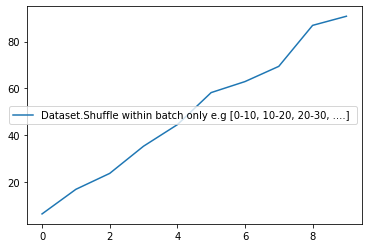

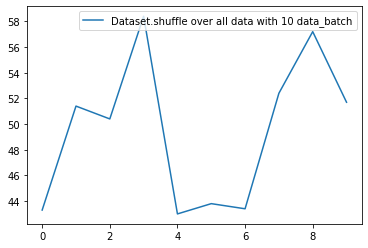


		Processing Epochs : Dataset.shuffle + batch + epoch


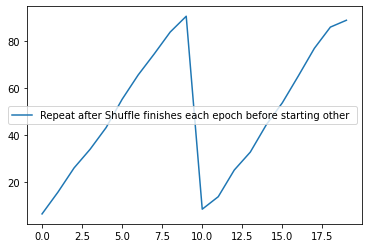

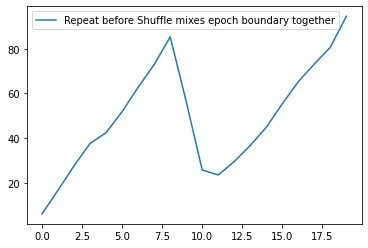

In [37]:
import matplotlib.pyplot as plt
d_100 = tf.data.Dataset.from_tensor_slices([i for i in range(100)])

def f(x):
  return x+2

def _plot(data, label):
  plt.plot(data, label=label)
  plt.legend()
  plt.show()


hprint('Dataset.map():')
print('All elements Increment by 1')
print(list(d_mem.map(lambda x: x+1, num_parallel_calls=2).as_numpy_iterator() ))
print(f'Using function ',list(d_mem.map(lambda x: f(x), num_parallel_calls=2).as_numpy_iterator() ))

hprint('Dataset.map(): Read Data from TFRecordDataSet using MAP()')
def tf_parse_byte_to_examples(tfrecord_example):
  # Parse example into tensors
  example = tf.io.parse_example(tfrecord_example[tf.newaxis], {
                  'image/encoded': tf.io.FixedLenFeature(shape=(), dtype=tf.string),
                  'image/text':    tf.io.FixedLenFeature(shape=(), dtype=tf.string)
                  })
  return example['image/encoded'][0], example['image/text'][0]

tfrecord_iter = next(iter(fsns_tfrecord))
tfrecord_examples = fsns_tfrecord.map(tf_parse_byte_to_examples)
for img, text in tfrecord_examples.take(1):
  print(text)
  # print(img)
  plt.imshow(tf.image.decode_png(img))
  plt.show()


hprint('Dataset.reduce():')
print('With initial intitial_state or starting_val')
print(f'=10 ', d_mem.reduce( 10,  lambda x,y: x+y).numpy() )
print(f'=0 ', d_mem.reduce( 0,  lambda x,y: x+y).numpy() )

hprint('Dataset.shuffle() + batch()')
d_mem1 = tf.data.Dataset.from_tensor_slices([1,2,3,4,5,6,7,8,9]) 
_plot([batch.numpy().mean() for batch in d_100.shuffle(buffer_size=10).batch(10) ], \
       label="Dataset.Shuffle within batch only e.g [0-10, 10-20, 20-30, ....] ")
_plot([batch.numpy().mean() for batch in d_100.shuffle(buffer_size=100, seed=6).batch(10) ], \
        label= "Dataset.shuffle over all data with 10 data_batch")

hprint('Processing Epochs : Dataset.shuffle + batch + epoch')
shuffled = d_100.shuffle(buffer_size=10).batch(10).repeat(2)
_plot([batch.numpy().mean() for batch in shuffled ], label="Repeat after Shuffle finishes each epoch before starting other ")

shuffled = d_100.repeat(2).shuffle(buffer_size=10).batch(10)
_plot([batch.numpy().mean() for batch in shuffled ], label="Repeat before Shuffle mixes epoch boundary together")


### Data Sampling
  - sample_from_datasets(): Needs dataset per class
  - dataset.filter: Work but data is loaded  twice
  - rejection_sample: Balance and loads it only once

In [70]:
## REF: Sampling : https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
pos_feature = [ ['01','02'], ['11','12'], ['21', '22'], ['31', '32']  ]
pos_label = [[1], [1], [1], [1]]
neg_feature = [ ['-01','-02'], ['-11','-12']   ]
neg_label = [[0], [0]]

pos_ds = tf.data.Dataset.from_tensor_slices(( pos_feature , pos_label ))
neg_ds = tf.data.Dataset.from_tensor_slices(( neg_feature , neg_label ))

hprint('sample_from_datasets: Balanced Sampling ')
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 1.0] )
resampled_ds = resampled_ds.batch(4)
for x in resampled_ds.take(1):
  print( x)

hprint("sample_from_datasets: Trying undersampling")
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.25, 1.0] )
resampled_ds = resampled_ds.batch(3)
for x in resampled_ds.take(1):
  print( x)

hprint('Filter() : Loads data twice')
neg_credit_card = (credit_card_ds.unbatch().filter( lambda X,Y: Y==0).repeat() )
pos_credit_card = (credit_card_ds.unbatch().filter(lambda X,Y: Y==1).repeat() )
# for  X,Y in pos_credit_card.batch(10).take(1):
#   print(Y.numpy())
balanced_ds = tf.data.experimental.sample_from_datasets([pos_credit_card, neg_credit_card],\
                      weights=[0.5, 0.5]).batch(6)
for X,Y in balanced_ds.take(5):
  print(Y.numpy() )

hprint('BEST rejection_resample: Data balancing with rejection_resample: ')
def get_Y(X, Y):  
  return Y
resampler = tf.data.experimental.rejection_resample(get_Y, target_dist=[0.5, 0.5] )
resampled_ds = credit_card_ds.unbatch().apply(resampler).batch(6)
# Because resampled_ds return (Y,example) however example in this particular case already contains(X,Y)
# hence we need to drop thee extra Y 
balanced_ds = resampled_ds.map(lambda Y, X_n_Y: X_n_Y  )
for X,Y in balanced_ds.take(5):
  print( Y.numpy())
  # print(X)


		sample_from_datasets: Balanced Sampling 
(<tf.Tensor: shape=(4, 2), dtype=string, numpy=
array([[b'-01', b'-02'],
       [b'-11', b'-12'],
       [b'01', b'02'],
       [b'11', b'12']], dtype=object)>, <tf.Tensor: shape=(4, 1), dtype=int32, numpy=
array([[0],
       [0],
       [1],
       [1]], dtype=int32)>)

		sample_from_datasets: Trying undersampling
(<tf.Tensor: shape=(3, 2), dtype=string, numpy=
array([[b'-01', b'-02'],
       [b'01', b'02'],
       [b'-11', b'-12']], dtype=object)>, <tf.Tensor: shape=(3, 1), dtype=int32, numpy=
array([[0],
       [1],
       [0]], dtype=int32)>)

		Filter() : Loads data twice
[0 1 1 0 0 1]
[1 1 1 1 0 0]
[0 0 0 1 0 1]
[1 1 0 1 1 1]
[0 0 0 1 1 1]

		BEST rejection_resample: Data balancing with rejection_resample: 
[1 0 0 0 0 0]
[1 1 0 0 0 0]
[1 1 1 0 0 0]
[1 1 0 1 1 0]
[0 1 1 1 1 0]


## TF.Batch :
Create dataset batch to be used in the training
**[Caution]** : The batch sizes can be uneven because equal size batching may not be possible. e.g break 3 element into batch of 2. It may create warning/ errors due to different size. 

## TF Transform : Using Python function
If you want to use the python function inside teh tensorflow pipeline, you can do so in two ways
  - Autograph: Use the function directly in the TF graphs. 
    - Pro: Easy to use
    - Con: Can covert some but not all python codes
  - tf.py_function : Define the python function as tf function during its use, indicating that it needs to converted into the tf code
    - Pro: Can write  arbitary code and will be supported by TF pipeline without throwing any error
    - Con: Generally results in worse performance
      - Not parallelised

In [24]:
hprint(" BATCH SIZE : Dataset into batches ")
print(f'Uneven batch size :', list( d_mem.batch(2).as_numpy_iterator() ) )
print(f'Even batch size by dropping remainder :', \
      list( d_mem.batch(2, drop_remainder=True).as_numpy_iterator() ) )
print(f'Even batch size with padding :', \
      list( d_mem.batch(2).padded_batch(2, padded_shapes=[None]).as_numpy_iterator() ) )

hprint("tf.py_function() ")
def upper1(x: tf.Tensor):
  return x+10
person_modf = person.map( lambda x : tf.py_function( func=upper1, inp=[x['age']], Tout=tf.int32) )
print(f'Pre-increment  Age  =', list(person.map(lambda x: x['age']).as_numpy_iterator()) )
print(f'Post-Increment Age  =', list(person_modf.as_numpy_iterator()) )

hprint("Time Series Batch")
def time_shift(batch, shift=1):
  return batch[:-shift], batch[shift:]

print("\nShifting with interval : 1")
t_shift_batch = d_100.batch(3, drop_remainder=True).map(time_shift)
for features, label in t_shift_batch.take(3):
  print(f'Feat : ', features.numpy(), ' ==> Label :', label.numpy())

print("\nShifting with interval : 5")
t_shift_batch = d_100.batch(10, drop_remainder=True).map(lambda x: time_shift(x, 5))
for features, label in t_shift_batch.take(3):
  print(f'Feat : ', features.numpy(), ' ==> Label :', label.numpy())

hprint('Time Series batching can also be achieved with Dataset.window')
print('See https://www.tensorflow.org/guide/data#using_window')


		 BATCH SIZE : Dataset into batches 
Uneven batch size : [array([1, 2], dtype=int32), array([3], dtype=int32)]
Even batch size by dropping remainder : [array([1, 2], dtype=int32)]
Even batch size with padding : [array([[1, 2],
       [3, 0]], dtype=int32)]

		tf.py_function() 
Pre-increment  Age  = [18, 30]
Post-Increment Age  = [28, 40]

		Time Series Batch

Shifting with interval : 1
Feat :  [0 1]  ==> Label : [1 2]
Feat :  [3 4]  ==> Label : [4 5]
Feat :  [6 7]  ==> Label : [7 8]

Shifting with interval : 5
Feat :  [0 1 2 3 4]  ==> Label : [5 6 7 8 9]
Feat :  [10 11 12 13 14]  ==> Label : [15 16 17 18 19]
Feat :  [20 21 22 23 24]  ==> Label : [25 26 27 28 29]

		Time Series batching can also be achieved with Dataset.window
See https://www.tensorflow.org/guide/data#using_window


## TFX Transform: In Progress
Since the transformation is always a part of the modeling, rather than keeping the transformation independent of the model, it is always useful/ important to keep it as a part of the model. TFX allows us to do so with
  - tf.feature_column.categorical_column_with_hash_bucket('embark_town', 32)
  - tf.feature_column.categorical_column_with_vocabulary_list('class', ['First', 'Second', 'Third']) 
  - tf.feature_column.numeric_column('age')

## Optimisation
There are couple of things that can be done to speed up the.
  - **prefetch** :  If you are reading the data off the disk, then often the latency is involved in disk reads. You can avoid this latency and hence faster training by prefetching  some batch of data.
  - **TF.py_function vs TF.distribute.Server**:
The tf.py_function must run in the same address as the python program including the device, hence if you are using the distributed Tensorflow you must  use the tf.distribute.Server instead

In [0]:
print('Orig d_mem :', list( d_mem.as_numpy_iterator() ))
# This one fetches all because we have only one  list in the dataset
print('Prefetches all ', list( d_mem.prefetch(1).as_numpy_iterator() ))
print('', list( d_mem.batch(1).prefetch(1).as_numpy_iterator() ))

## CheckPointing : Stop/ record/ resume Model Training
If we are training a model for a  very long time, we can stop and record the progress  and then resume it from the last state. We can checkpoint
  - Model variables
  - Progress of dataset iterator (To resume the training mid-epoch rather than restart with the new epoch everytime)


In [85]:
hprint("Simple Checkpointing Demo")

iterator = iter(d_100.batch(2))
checkpoint = tf.train.Checkpoint(step=tf.Variable(0), iterator=iterator)
manager = tf.train.CheckpointManager(checkpoint, directory='/tmp/simple_checkpoint/demo', max_to_keep=3)

print('Epoch 1: Simulation Batch 1: 0-10 ', [next(iterator).numpy() for _ in range(5) ])
print('Epoch 1: Simulation Batch 2: 10-20',[next(iterator).numpy() for _ in range(5) ])
save_path= manager.save()
print('Epoch 1: Simulation Batch 3: 20-30 ',[next(iterator).numpy() for _ in range(5) ])
print('Simulating Model Training Stopped. STOPPED')

print('\nEpoch 1: Resuming Model Training from checkpoint.')
checkpoint.restore(manager.latest_checkpoint)
print( [next(iterator).numpy() for _ in range(5)] )

print('\nWhere Epoch 1 : Ends at 90-100 for 100 element in the d_100 dataset')


		Simple Checkpointing Demo
Epoch 1: Simulation Batch 1: 0-10  [array([0, 1], dtype=int32), array([2, 3], dtype=int32), array([4, 5], dtype=int32), array([6, 7], dtype=int32), array([8, 9], dtype=int32)]
Epoch 1: Simulation Batch 2: 10-20 [array([10, 11], dtype=int32), array([12, 13], dtype=int32), array([14, 15], dtype=int32), array([16, 17], dtype=int32), array([18, 19], dtype=int32)]
Epoch 1: Simulation Batch 3: 20-30  [array([20, 21], dtype=int32), array([22, 23], dtype=int32), array([24, 25], dtype=int32), array([26, 27], dtype=int32), array([28, 29], dtype=int32)]
Simulating Model Training Stopped. STOPPED

Epoch 1: Resuming Model Training from checkpoint.
[array([20, 21], dtype=int32), array([22, 23], dtype=int32), array([24, 25], dtype=int32), array([26, 27], dtype=int32), array([28, 29], dtype=int32)]

Where Epoch 1 : Ends at 90-100 for 100 element in the d_100 dataset


In [0]:
REF :https://www.tensorflow.org/tutorials/structured_data/imbalanced_data